# HW4: Linear Regression by Gradient Descent with Regularization

This ipynb file allows you to do HW4.

Your task is to implement a Regularized Linear Regression model and evaluate it applying some machine learning diagnostics to examine the underfitting vs. overfitting effect.

The goal aims at predicting the amount of water flowing out of a dam using the change of water level in a reservoir. It is a rather simple data set (just a single feature), so we will be able to visualize the fitting in 2D plots.

In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#np.set_printoptions(precision=4)
#np.set_printoptions(suppress=True)

## Load Data

In [35]:
# Load the data (in .mat format)
from scipy.io import loadmat
data = loadmat('hw4_data.mat')
# loadmat returns a dictionary of the data

# Training set
Xtr = data['X']
ytr = data['y']

# Validation set
Xcv = data['Xval']
ycv = data['yval']

# Test set
Xtest = data['Xtest']
ytest = data['ytest']

#print(Xtr,ytr)
print(Xtr.shape, ytr.shape)
print(Xcv.shape, ycv.shape)
print(Xtest.shape, ytest.shape)

(12, 1) (12, 1)
(21, 1) (21, 1)
(21, 1) (21, 1)


The training set contains less samples (12) than the validation (cv) and the test (21). I guess it is prepared this way to find some over-fitting problems during the homework.

## Explore data

In [36]:
# Plot scatter 
def plotScatter(x,y,title,x_title,y_title):
    plt.scatter(x,y,c="g")
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.grid()#網格
    plt.show()

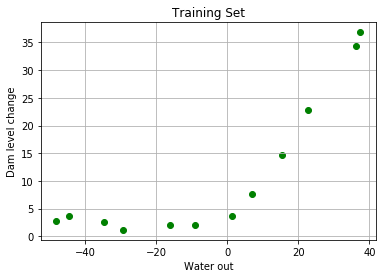

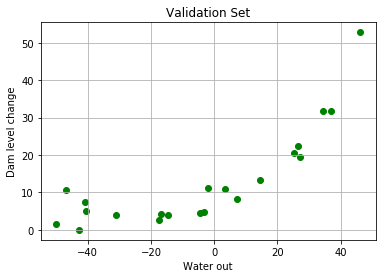

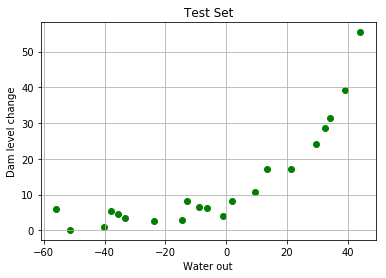

In [37]:
plotScatter(Xtr,ytr,'Training Set','Water out','Dam level change')
plotScatter(Xcv,ycv,'Validation Set','Water out','Dam level change')
plotScatter(Xtest,ytest,'Test Set','Water out','Dam level change')

## Regularized Linear Regression Model

In [38]:
# function to compute h(x),m is data size,k is the number of thetas,X:m*2,theta:1*k,y:m*1.
def h(X, theta):
    return X*theta.T

# function to compute the cost of the entire set as (1/2m)SUM((X·theta'-y)^2) + regularization
def computeCost(theta, X, y, lmbda):
    y_hat = np.sum(h(X, theta),axis=1,keepdims=True) 
    #keepdims=True可以讓維度維持在我們想要的狀態，也就是(12,1)，沒加的話會變(12,)，待會算y_hat-y後維度就不會是我們所想要的(12,1)
    #會變成(12*12)
    cost_term = np.sum(np.power(y_hat-y,2))
    regu_term = lmbda*(np.sum(np.power(theta,2)[1:])) #theta_0不用regularize
    return (cost_term + regu_term)/(2*len(X))

In [39]:
# function that computes the gradient for each theta parameter (single step, not the gradient algorithm)
# 此function只要計算theta後被減的項
def computeGradient(theta, X, y, lmbda):
    y_hat = np.sum(h(X, theta),axis=1,keepdims=True)
    gradi = ((y_hat-y)*X).mean(0)
    regu_term = (lmbda/len(X))*theta[1:]
    gradi[1:] = gradi[1:] + regu_term #regularization
    return gradi

In [40]:
# insert 'ones' column in X matrices
Xtr   = np.insert(Xtr  ,0,1,axis=1) 
#0 means the 0th row or 0th column or 0th element, 1 is the insert value, axis=1 means inset by column
Xcv   = np.insert(Xcv  ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)
print(Xtr.shape, ytr.shape)
print(Xcv.shape, ycv.shape)
print(Xtest.shape, ytest.shape)

(12, 2) (12, 1)
(21, 2) (21, 1)
(21, 2) (21, 1)


In [41]:
# set theta starting values (theta0, theta1) initilaized to (0,0)
thetaStart = np.zeros(Xtr.shape[1], dtype=np.float)
print(thetaStart.shape)

(2,)


In [42]:
# Compute the cost with thetaStart = (0,0) (should be around 140.95...)
computeCost(thetaStart, Xtr, ytr, 0)

140.95412088055392

In [43]:
# Compute the gradient with thetaStart = (0,0) (should be around [-11.21..., -245.65...)
computeGradient(thetaStart, Xtr, ytr, 0)

array([ -11.21758933, -245.65199649])

In [44]:
from scipy import optimize

# just a helper function to call scipy fmin optimzation function
def optimizeTheta(X, y, theta, lmbda):
    # using fmin_tnc (we need to pass gradient)
    result = optimize.fmin_tnc(func=computeCost,          #要最小化的函數
                               x0=theta,                  #要變動的值
                               args=(X, y, lmbda),        #要傳進函式的參數
                               fprime=computeGradient)    #Gradient function
    return result[0], computeCost(result[0], X, y, lmbda)   
    
    # using minimize (no need to pass gradient)
    #result = optimize.minimize(computeCost, theta, args=(X, y, lmbda),  method='BFGS', options={"maxiter":500, "disp":False} )
    #return result.x, result.fun

In [45]:
# And optimize!
thetaFinal, minCost = optimizeTheta(Xtr, ytr, thetaStart, 0)
print(thetaFinal, minCost)

[13.08790351  0.36777923] 22.373906495108912


Text(0,0.5,'Dam level change')

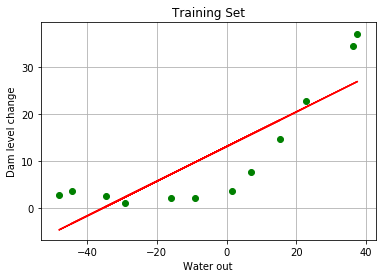

In [46]:
#plotScatter(Xtr[:,1],ytr,'Training Set','Water out','Dam level change')
plt.plot(Xtr[:,1], thetaFinal[0] + thetaFinal[1]*Xtr[:,1], 'r-')
plt.scatter(Xtr[:,1],ytr,c='g')
plt.grid()
plt.title('Training Set')
plt.xlabel('Water out')
plt.ylabel('Dam level change')

Obvously, the single-feature linear fit is not a good model (underfit, high bias)... But let's evaluate with some more formal diagnostics.

## Learning curves

A learning curve plots training and validation error as a function of training set size.

In [47]:
# set a theatStart initialized to zeros
thetaStart = np.zeros(Xtr.shape[1], dtype=np.float)

# regularization parameter (note it is not used to compute Jtr and Jcv)
lmbda = 0

# init arrays to store output data for later plotting
m_values, j_tr, j_cv = [], [], []

# loop over training subsets of different sizes (1:1,1:2,1:3,...)
for m in range(1, Xtr.shape[0]+1, 1): #range(1, Xtr.shape[0]+1, 1)=1,2,3,...,12
    m_values.append(m)
    besttheta = optimizeTheta(Xtr[0:m,:], ytr[0:m], thetaStart, lmbda)[0]
    j_tr.append(computeCost(besttheta, Xtr[0:m,:], ytr[0:m], lmbda))
    j_cv.append(computeCost(besttheta, Xcv, ycv, lmbda))
    
# check sizes
#print(m_values, j_tr, j_cv)
print(len(m_values), len(j_tr), len(j_cv))

12 12 12


In [48]:
# function that plots the learning curve
def plotLearningCurve(m_values,j_tr,j_cv,title,x_title,y_title):
    plt.figure(figsize=(6,4))
    plt.plot(m_values, j_tr, 'g-', label='Training')
    plt.plot(m_values, j_cv, 'r-', label='Validation')
    plt.grid(True)
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.legend()

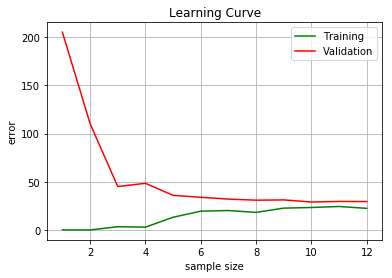

In [49]:
plotLearningCurve(m_values, j_tr, j_cv,'Learning Curve', 'sample size','error')

We can see that both Jtr and Jcv are large (cost around 20) for large number of training samples m. This indicates that this is a model with high bias (underfitted); that is, the model is too simple for the data. We actually knew this when we plotted the data scatter with the regression line.

## Polynomial regression model

In order to try to solve the high bias problem we will use a more complex model with more features. Since we have no more information about the damp, we will use a polynomial model where the new features will actually be waterlevel^n.

h(x) = theta0 + theta1·waterLevel + theta2·waterLevel^2 + ... = theta0 + theta1·x1 + theta2·x2 + ...

### Create polynomial features

In [50]:
# function that creates the new polynomial features
def generatePolynomialFeatures(X, p):
    X_withoutinterceptlist = []
    for i in range(1,p+1,1):
        X_withoutinterceptlist.append(np.power(X[:,1],i))
    X_withoutintercept = np.column_stack(X_withoutinterceptlist)
    X_poly = np.insert(X_withoutintercept  ,0,1,axis=1)
    return X_poly

In [51]:
# function that normalizes a data set (x-mu/sigma)
def normalizeFeatures(X):
    
    Xnorm = X.copy()
    
    # compute means and standdard deviations (column-wise)
    means = np.mean(Xnorm,axis=0)
    std_devs = np.std(Xnorm,axis=0,ddof=1)
    
    # compute normalization
    Xnorm[:,1:] = ( Xnorm[:,1:] - means[1:] ) / std_devs[1:]
        
    return Xnorm, means, std_devs

### Train Polynomial Model

In [52]:
# function that plots the polynomial regression line on top of the scatter data plot
def plotPolynomialFit(theta, original_means, original_std_devs):
    
    # create linear space to plot
    points_to_plot = 50
    x_values = np.linspace(-60, 60, points_to_plot)

    # construct 'fake' x matrix (representing all the points to plot) to compute h(x)
    x_mat = np.ones((points_to_plot,1))
    x_mat = np.insert(x_mat, x_mat.shape[1], x_values.T, axis=1)
    x_mat = generatePolynomialFeatures(x_mat, len(theta)-1)

    # normalize using original means and std_devs
    x_mat[:,1:] = x_mat[:,1:] - original_means[1:]
    x_mat[:,1:] = x_mat[:,1:] / original_std_devs[1:]
    
    # convert to matrices to use notation of algebra operations
    theta = np.matrix(theta)
    x_mat = np.matrix(x_mat)
    
    # plot regression line
    plt.plot(x_values, h(x_mat, theta), 'r-')

In [53]:
# function that creates the normalized polynomial features
def createPolynomialFeaturesAndTrain(X, y, poly_degree, lmbda):
    X_poly = generatePolynomialFeatures(X, poly_degree)
    nor_X_poly,original_means,original_std_devs = normalizeFeatures(X_poly)
    thetaStart = np.zeros(nor_X_poly.shape[1], dtype=np.float)
    theta_final = optimizeTheta(nor_X_poly, y, thetaStart, lmbda)[0]
    return nor_X_poly, original_means, original_std_devs, theta_final

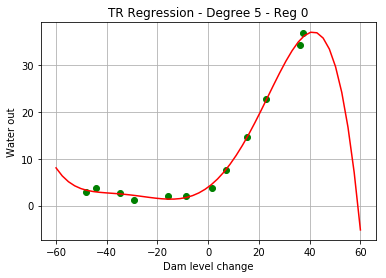

In [54]:
# degree of the polynomial model (polynomial features to construct)
poly_degree = 5

# regularization parameter (note it is not used to compute Jtr and Jcv)
lmbda = 0

# create the normalized polynomial features and train the model
Xtr_poly, original_means, original_std_devs, theta_final = createPolynomialFeaturesAndTrain(Xtr, ytr, poly_degree, lmbda)

# plot scatter data and regression line
plt.scatter(Xtr[:,1],ytr,c='g')
plt.grid()
plt.title('TR Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)

The polynomial fit (of degree 5) clearly fits very well the training points (so we are expecting a low training cost). But also note that it quickly drops for large dam level changes, so this indicates that predicting other data with this model might not end up very well, hence a large validation(cv) error is expected.

### Learning Curves

In [55]:
# function that fits for different sample sizes and plots the learning curves
def PlotPolynomialLearningCurvesForDifferentSampleSizes(Xtr_poly, ytr, Xcv, ycv, poly_degree, lmbda):

    # set a theatStart initialized to zeros
    thetaStart = np.zeros(Xtr_poly.shape[1], dtype=np.float)

    # create the normalized polynomial features up to poly_degree of the validation set
    Xcv_poly = generatePolynomialFeatures(Xcv, poly_degree)
    Xcv_poly, original_means_cv, original_std_devs_cv = normalizeFeatures(Xcv_poly)

    # init arrays to store output data for later plotting
    m_values, j_tr, j_cv = [], [], []

    # loop over training subsets of different sizes (1:1,1:2,1:3,...)
    for m in range(1,Xtr_poly.shape[0]+1, 1):

        m_values.append(m)

        # train the subset and get theta that fits the given subset
        theta_subset, cost_subset = optimizeTheta(Xtr_poly[:m,:], ytr[:m], thetaStart, lmbda)

        # compute cost of the training subset (no regularization)
        j_tr.append(computeCost(theta_subset, Xtr_poly[:m,:], ytr[:m], 0))

        # compute cost of the validation(cv) subset (all samples in validation, not 1:m)(no regularization)
        j_cv.append(computeCost(theta_subset, Xcv_poly, ycv, 0))

    # check sizes
    print(len(m_values), len(j_tr), len(j_cv))

    # last cost value
    print(j_tr[-1], j_cv[-1])

    # plot the learning curves
    plotLearningCurve(m_values, j_tr, j_cv, 'Learning curves - Degree '+str(poly_degree)+' - Reg '+str(lmbda), 'sample size', 'error')


12 12 12
0.20849612409819687 14.519838574548793


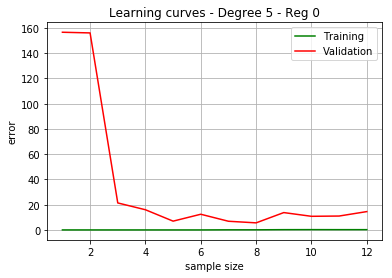

In [56]:
# Prepare for polynomial learning curves for different sample sizes and plot them
PlotPolynomialLearningCurvesForDifferentSampleSizes(Xtr_poly, ytr, Xcv, ycv, poly_degree=5, lmbda=0)

As expected, the training cost is much smaller than the validation cost (note the gap for large sample sizes). This indicates that the model has high variance (or it is overfitting).

Let's check how the model fits the Validation(CV) data. 

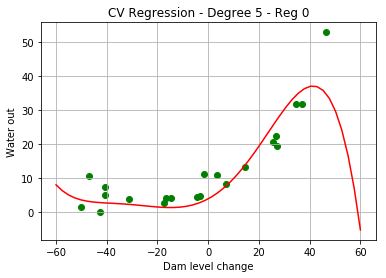

In [57]:
# plot validation scatter data and regression line
plt.scatter(Xcv[:,1:],ycv,c='g')
plt.grid()
plt.title('CV Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)

Clearly, an overfitted model... :(

### Adjusting different regularization values

12 12 12
1.9372439544627458 4.6056522333977785


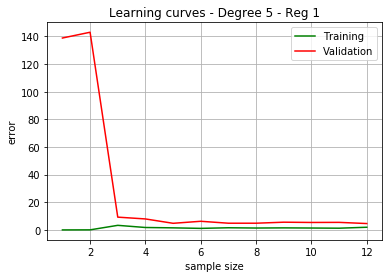

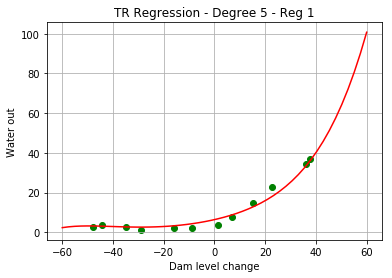

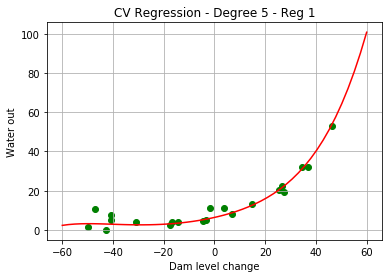

In [58]:
# degree of the polynomial model (polynomial features to construct)
poly_degree = 5

# regularization parameter (note it is not used to compute Jtr and Jcv)
lmbda = 1

# create the normalized polynomial features and train the model
Xtr_poly, original_means, original_std_devs, theta_final = createPolynomialFeaturesAndTrain(Xtr, ytr, poly_degree, lmbda)

# Prepare for polynomial learning curves for different sample sizes and plot them
PlotPolynomialLearningCurvesForDifferentSampleSizes(Xtr_poly, ytr, Xcv, ycv, poly_degree, lmbda)
plt.show()

# plot scatter data and regression line
plt.scatter(Xtr[:,1],ytr,c='g')
plt.grid()
plt.title('TR Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)
plt.show()

# plot validation scatter data and regression line
plt.scatter(Xcv[:,1],ycv,c='g')
plt.grid()
plt.title('CV Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)
plt.show()

With lmbda=1 we get a training error little bit larger (0.2=>1.93), but validation error much smaller (14=>4.6). This can be seen in the learning curves, much closer now. This means that we are reducing the high variance problem (so we are reducing the overfitting problem).

When we look at the regresison lines fitting training and validation data, it now looks much better.

So regularization (with lmbda=1) did a good job.

12 12 12
17.06120030635285 15.770405564517436


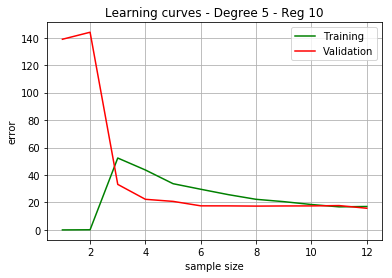

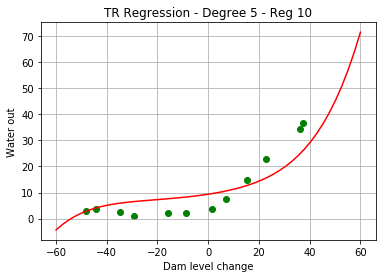

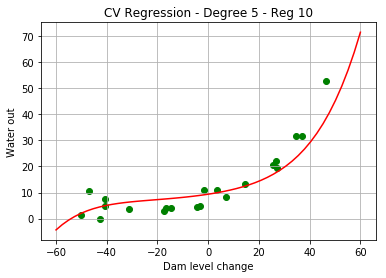

In [59]:
# degree of the polynomial model (polynomial features to construct)
poly_degree = 5

# regularization parameter (note it is not used to compute Jtr and Jcv)
lmbda = 10

# create the normalized polynomial features and train the model
Xtr_poly, original_means, original_std_devs, theta_final = createPolynomialFeaturesAndTrain(Xtr, ytr, poly_degree, lmbda)

# Prepare for polynomial learning curves for different sample sizes and plot them
PlotPolynomialLearningCurvesForDifferentSampleSizes(Xtr_poly, ytr, Xcv, ycv, poly_degree, lmbda)
plt.show()

# plot scatter data and regression line
plt.scatter(Xtr[:,1],ytr,c='g')
plt.grid()
plt.title('TR Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)
plt.show()

# plot validation scatter data and regression line
plt.scatter(Xcv[:,1],ycv,c='g')
plt.grid()
plt.title('CV Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)
plt.show()

With a much larger regularization factor (lmbda=10), both the training and validation(cv) error have the same value (around 16), but large. This indicates that with a so large regularization, we ended up with a high bias model now (underfitted).

### Choosing lambda with the validation set

Let's plot some learning curves for different lmbda values

100 100 100
Minimum Jcv at lambda = 1.3636363636363635 => cost = 4.546834489582457


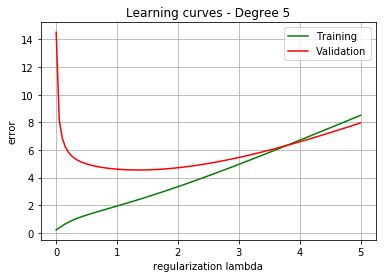

In [60]:
# degree of the polynomial model (polynomial features to construct)
poly_degree = 5

# set all lmbda values to try
lmbdas = np.linspace(0, 5, 100)

# create the normalized polynomial features up to poly_degree of the validation set
Xcv_poly = generatePolynomialFeatures(Xcv,poly_degree)
Xcv_poly, original_means_cv, original_std_devs_cv = normalizeFeatures(Xcv_poly)

# init arrays to store output data for later plotting
lmbda_values, j_tr, j_cv = [], [], []

for lmbda in lmbdas:
    lmbda_values.append(lmbda)
    opttheta = createPolynomialFeaturesAndTrain(Xtr, ytr, poly_degree, lmbda)[3] #第一個參數要放Xtr而不是Xtr_poly
    j_tr.append(computeCost(opttheta, Xtr_poly, ytr, 0))
    j_cv.append(computeCost(opttheta, Xcv_poly, ycv, 0))

# check sizes
print(len(lmbda_values), len(j_tr), len(j_cv))

# print lmbda with minimum j_cv
print('Minimum Jcv at lambda = ' + str(lmbda_values[j_cv.index(min(j_cv))]) + ' => cost = ' + str(min(j_cv)))

# plot the learning curves
plotLearningCurve(lmbda_values, j_tr, j_cv, 'Learning curves - Degree '+str(poly_degree), 'regularization lambda', 'error')

So a lambda=1.36 is the best we found to use with a polynomial regression model of degree 5!

### Test error

Let's compute the final test error with the polynomial model of degree 5 and a lambda of 1.36.

Final test cost => 8.381581085401798


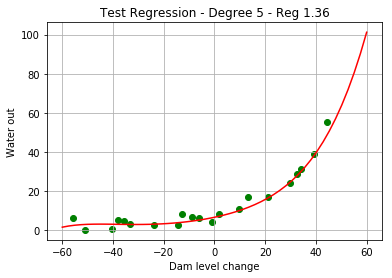

In [61]:
# degree of the polynomial model (polynomial features to construct)
poly_degree = 5

# regularization parameter
lmbda = 1.36

# create the normalized polynomial features and train the model
Xtr_poly, original_means, original_std_devs, theta_final = createPolynomialFeaturesAndTrain(Xtr, ytr, poly_degree, lmbda)

# create the normalized polynomial features up to poly_degree of the test set
# compute test cost
Xtest_poly = generatePolynomialFeatures(Xtest,poly_degree)
Xtest_poly, original_means_test, original_std_devs_test = normalizeFeatures(Xtest_poly)
j_test = computeCost(theta_final, Xtest_poly, ytest, 0)

print("Final test cost => " + str(j_test))

# plot scatter data and regression line
plt.scatter(Xtest[:,1:],ytest,c='g')
plt.grid()
plt.title( 'Test Regression - Degree '+str(poly_degree)+' - Reg '+str(lmbda))
plt.ylabel('Water out')
plt.xlabel('Dam level change')
plotPolynomialFit(theta_final, original_means, original_std_devs)

We finally got a test cost of 8.38 (while our best validation(cv) cost was 4.54).